## 0. Imports

In [65]:
import os

import matplotlib.pyplot as plt
import plotly.express as px

import numpy as np
import pandas as pd
from collections import Counter
import functools
import umap

from sklearn import decomposition
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

In [2]:
plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams['font.size'] = 12

## 1. Data Setup

In [3]:
seq_data_root = "sample_sequences"

In [4]:
groups = os.listdir(seq_data_root)
groups

['FU', 'HD', 'BL']

In [5]:
cols = ['cdr3aa', 'v', 'count', 'sample']
data = pd.DataFrame(columns=cols)

In [6]:
voc_data = pd.DataFrame()

In [7]:
for group in groups:
    temp_dir = os.path.join(seq_data_root, group)
    
    for file in os.listdir(temp_dir):
        # sample_id = file.split('.')[1]
        temp_df = pd.read_csv(os.path.join(temp_dir, file), delimiter='\t')
        temp_df['sample'] = file
        data = data.append(temp_df, ignore_index=True)
        
        seq_count = list(zip(temp_df['cdr3aa'], temp_df['count']))
        
        sequences = []
        
        for seq, count in seq_count:
            sequences.extend([seq] * count)
        
        temp_voc = pd.DataFrame({'sample_id': file, 'seq': [sequences]})
        voc_data = voc_data.append(temp_voc, ignore_index=True)

In [8]:
voc_data.iloc[1].seq.__len__() == data[data['sample'] == '1056_2659_SA74_S74_L001_R1']['count'].sum()

False

## 2. Inverted Index and TFiDF

In [9]:
vocabulary = data.groupby('cdr3aa')['count'].sum().reset_index()

In [10]:
vocabulary

,cdr3aa,count
0,CAAALDKLIF,228
1,CAAAPLPSVGGHTDKLIF,15
2,CAAAPSSPVGFQDTNTDKLIF,410
3,CAAAQLGVADKLIF,56
4,CAAARYTRGQYTDKLIF,95
...,...,...
26465,YAGRQLGASMYTDKLIF,8
26466,YALGDTPRTLQGYTDKLIF,2
26467,YALGELAPKIATPWTDKLIF,6
26468,YALGELRGIQDTDKLIF,12


In [11]:
word_dict = {}
item_id = 1

for word in vocabulary.cdr3aa:
    word_dict[word] = item_id
    item_id += 1

In [12]:
word_dict

{'CAAALDKLIF': 1,
 'CAAAPLPSVGGHTDKLIF': 2,
 'CAAAPSSPVGFQDTNTDKLIF': 3,
 'CAAAQLGVADKLIF': 4,
 'CAAARYTRGQYTDKLIF': 5,
 'CAAAVSTDKLIF': 6,
 'CAADRGGIEDKLIF': 7,
 'CAADTVLLGDTGDKLIF': 8,
 'CAAEGVVSSWDTRQMFF': 9,
 'CAAELHFLRRLWGISPGSTDKLIF': 10,
 'CAAEPFLAEGELAKLIF': 11,
 'CAAERFGGALTAQLFF': 12,
 'CAAFGGLSRGKYTDKLIF': 13,
 'CAAFWPAGGYRVTDKLIF': 14,
 'CAAGAGGRLYTDKLIF': 15,
 'CAAGAPPGDKLIF': 16,
 'CAAGDSYRGTTFTDKLIF': 17,
 'CAAGEGLTGGYLVYTDKLIF': 18,
 'CAAGFPRWGKYTDKLIF': 19,
 'CAAGFYGWGSGRLYTDKLIF': 20,
 'CAAGLLWYGDKLIF': 21,
 'CAAGLPTGYEADKLIF': 22,
 'CAAGNWGIPYTDKLIF': 23,
 'CAAGPFLAEGELAKFIF': 24,
 'CAAGPFLAEGELAKLIF': 25,
 'CAAGPFLAEGELAKLTF': 26,
 'CAAGPFLAEGELAKLVF': 27,
 'CAAGPFLAEGEPAKLIF': 28,
 'CAAGPSPGTGGSDKLIF': 29,
 'CAAGQGANWGQYTDKLIF': 30,
 'CAAGQGANWGQYTDKPIF': 31,
 'CAAGRASTDKLIF': 32,
 'CAAGRVRDAADKLIF': 33,
 'CAAGTGGALYTDKLIF': 34,
 'CAAGTGGGPAFTDKLIF': 35,
 'CAAGVYLGLGILPPRRQLFF': 36,
 'CAAGVYTDKLIF': 37,
 'CAAGWGGPTNKYTDKLIF': 38,
 'CAAHEMGVVSDKLIF': 39,
 'CAAHPGGET

In [13]:
inverted_idx = {}
for word, item_id in word_dict.items():
    inverted_idx[item_id] = list(data[data['cdr3aa'] == word][['sample', 'count']] \
                                 .itertuples(index=False, name=None))

In [14]:
inverted_idx

{1: [('FU_CopyOfVDJTOOLS_.1168_FU-d_S73_L001_R2.txt', 3),
  ('FU_CopyOfVDJTOOLS_.1084_FU-d_S71_L001_R1.txt', 63),
  ('FU_CopyOfVDJTOOLS_.1153_FU_TCRD_S7_R1.txt', 41),
  ('BL_CopyOfVDJTOOLS_.1153_BL-d_S69_L001_R1.txt', 72),
  ('BL_CopyOfVDJTOOLS_.1008_BL-d_S70_L001_R1.txt', 49)],
 2: [('HD_VDJTOOLS_.14-2-TCRD_S52_L001_R1.txt', 15)],
 3: [('BL_CopyOfVDJTOOLS_.1082_2697_SA92_S92_L001_R1.txt', 410)],
 4: [('BL_VDJTOOLS_.1136_BL_8-7-TCRD_S42_L001_R1.txt', 56)],
 5: [('HD_VDJTOOLS_.3-4-TCRD_S32_L001_R1.txt', 95)],
 6: [('HD_VDJTOOLS_.2-2-TCRD_S22_L001_R1.txt', 96)],
 7: [('HD_VDJTOOLS_.14-2-TCRD_S52_L001_R1.txt', 120)],
 8: [('FU_CopyOfVDJTOOLS_.1145_FU-d_S53_L001_R1.txt', 259),
  ('FU_CopyOfVDJTOOLS_.1146_FU-d_S95_L001_R2.txt', 18),
  ('FU_CopyOfVDJTOOLS_.1152_FU-d_S94_L001_R1.txt', 14),
  ('BL_CopyOfVDJTOOLS_.1145_BL-d_S67_L001_R1.txt', 139),
  ('BL_CopyOfVDJTOOLS_.1120_BL-d_S56_L001_R1.txt', 56),
  ('BL_CopyOfVDJTOOLS_.1149_BL-d_S68_L001_R1.txt', 26),
  ('BL_CopyOfVDJTOOLS_.1112_BL-d_S66_

In [15]:
tfidf = TfidfVectorizer(input='content', lowercase=False, tokenizer=lambda text: text)
result = tfidf.fit_transform(voc_data.seq)
dense_result = result.todense()
tfidf_df = pd.DataFrame(dense_result, 
                        index=voc_data['sample_id'], 
                        columns=tfidf.get_feature_names_out())


In [16]:
tfidf_df = tfidf_df.reset_index()
tfidf_df

,sample_id,CAAALDKLIF,CAAAPLPSVGGHTDKLIF,CAAAPSSPVGFQDTNTDKLIF,CAAAQLGVADKLIF,CAAARYTRGQYTDKLIF,CAAAVSTDKLIF,CAADRGGIEDKLIF,CAADTVLLGDTGDKLIF,CAAEGVVSSWDTRQMFF,...,YACDVLGDTDKLIF,YACDVLGTRDKLIF,YACDVLPTERLGDRDKLIF,YAFLFLRYWGKSDKLIF,YAFRFPTSFLWRGKRDTDKLIF,YAGRQLGASMYTDKLIF,YALGDTPRTLQGYTDKLIF,YALGELAPKIATPWTDKLIF,YALGELRGIQDTDKLIF,YARDKVSTGGDHSTDKLIF
0,FU_VDJTOOLS_.1231_FU_17-8-TCRD_S64_L001_R1.txt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,FU_CopyOfVDJTOOLS_.1056_2659_SA74_S74_L001_R1.txt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,FU_CopyOfVDJTOOLS_.1124_FU_TCRD_S4_R1.txt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,FU_CopyOfVDJTOOLS_.1120_FU-d_S52_L001_R1.txt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,FU_VDJTOOLS_.3001_FU_11-6-TCRD_S48_L001_R1.txt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,BL_VDJTOOLS_.3020_BL_12-3-TCRD_S49_L001_R1.txt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
146,BL_CopyOfVDJTOOLS_.1013_2565_SA82_S82_L001_R1.txt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
147,BL_CopyOfVDJTOOLS_.1121_BL-d_S91_L001_R1.txt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
148,BL_CopyOfVDJTOOLS_.1054_2630_SA69_S69_L001_R1.txt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 3. Visualizations

In [74]:
colors = ['#f07171']*55 + ['#2a37c7']*29 + ['#f52f2f']*66

In [75]:
X = tfidf_df[tfidf_df.columns[1:]]

In [76]:
sc = StandardScaler()
scaler = StandardScaler()
scaler.fit(X) 

X_scaled = scaler.transform(X)

### 3.1 PCA

In [77]:
pca = decomposition.PCA(n_components=2)
pca.fit(X)

X_2D = pca.transform(X)

Text(0.5, 1.0, '')

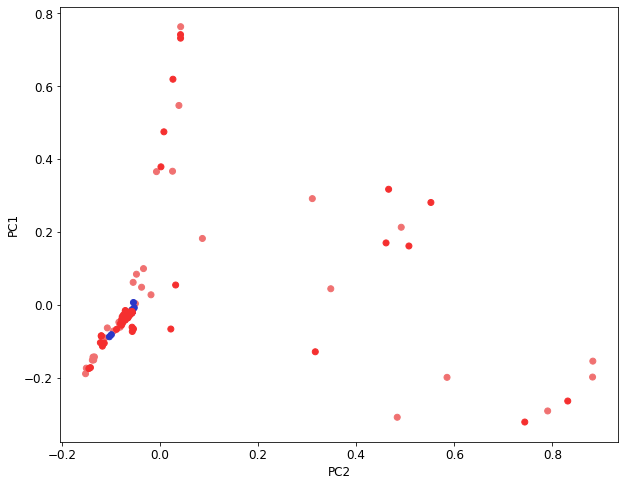

In [79]:
plt.scatter(X_2D[:, 0], X_2D[:, 1], c=colors)
plt.xlabel('PC2')
plt.ylabel('PC1')
plt.title('')

In [68]:
fig = px.scatter_3d(x=Xax, y=Yax, z=Zax, color=colors)
fig.show()

### 3.2 UMAP

In [45]:
reducer = umap.UMAP()

In [83]:
embedding_2D = reducer.fit_transform(X)
embedding_2D.shape

(150, 2)

Text(0.5, 1.0, 'UMAP w/ unscaled data')

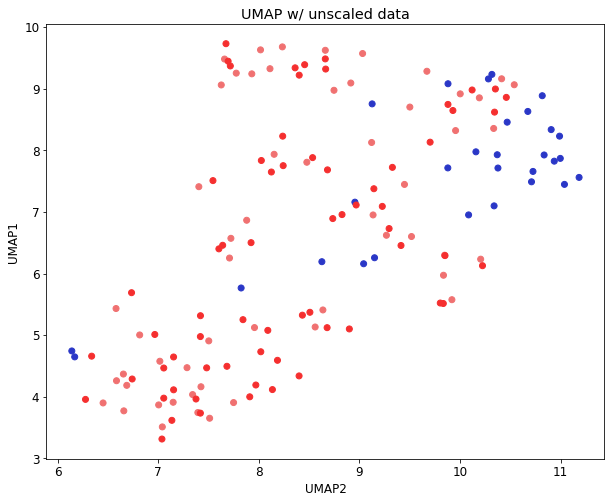

In [85]:
plt.scatter(embedding_2D[:, 0], embedding_2D[:, 1], c=colors)
plt.xlabel('UMAP2')
plt.ylabel('UMAP1')
plt.title('UMAP w/ unscaled data')

In [88]:
reducer_3D = umap.UMAP(n_components=3)

embedding_3D = reducer_3D.fit_transform(X)
embedding_3D.shape

(150, 3)

In [90]:
fig = px.scatter_3d(x=embedding_3D[:, 0], y=embedding_3D[:, 1], z=embedding_3D[:, 2], color=colors)
fig.show()